# Buy when Yields are Low

In [1]:
import datetime as dt
import pandas as pd
import yfinance as yf

C:\Users\tomw1\AppData\Local\Temp\ipykernel_3980\4020808254.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Rules

- Buy S&P 500 at the close when the 10 year yeidl drops below its 15-day exponential moving average; and
- Exit at the close when the yield crosses above its 15-day exponential moving average.

In [2]:
def calculate_ema(data, window=15):
    # Calculate the exponential moving average
    ema = data.ewm(span=window, adjust=False).mean()
    return ema


In [3]:
START = dt.date(2023, 1, 1)

In [4]:
ty10 = yf.download("^TNX", progress=False)["Close"]
sp500 = yf.download("SPY", progress=False)["Close"]

ty10 = ty10[ty10.index.date >= START]
sp500 = sp500[sp500.index.date >= START]

C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [5]:
ty10_15_day_ma = calculate_ema(data=ty10, window=15)

In [6]:
buy_signal = (ty10 < ty10_15_day_ma).astype(int)
sell_signal = (ty10 > ty10_15_day_ma).astype(int)
signal1 = buy_signal - 0 * sell_signal
(signal1 != 0).mean()

0.4316546762589928

In [7]:
buy_signal = (ty10 > ty10_15_day_ma).astype(int)
sell_signal = (ty10 < ty10_15_day_ma).astype(int)
signal2 = buy_signal - 0 * sell_signal
(signal2 != 0).mean()

0.564748201438849

In [8]:
hodl_signal = pd.Series(1, index=signal1.index)

In [9]:
sp500_rets = sp500.pct_change().shift(-1)
sp500_rets.head(5)

Date
2023-01-03    0.007720
2023-01-04   -0.011413
2023-01-05    0.022932
2023-01-06   -0.000567
2023-01-09    0.007013
Name: Close, dtype: float64

In [10]:
portfolio1_value = ((sp500_rets * signal1).dropna() + 1).cumprod()
portfolio1_ret = (sp500_rets * signal1).dropna().cumsum()
portfolio1_value.head(5)

Date
2023-01-03    1.000000
2023-01-04    0.988587
2023-01-05    1.011257
2023-01-06    1.010684
2023-01-09    1.017771
Name: Close, dtype: float64

In [11]:
portfolio2_value = ((sp500_rets * signal2).dropna() + 1).cumprod()
portfolio2_ret = (sp500_rets * signal2).dropna().cumsum()
portfolio2_value.head(5)

Date
2023-01-03    1.0
2023-01-04    1.0
2023-01-05    1.0
2023-01-06    1.0
2023-01-09    1.0
Name: Close, dtype: float64

In [12]:
hodl_value = ((sp500_rets * hodl_signal).dropna() + 1).cumprod()
hodl_ret = (sp500_rets * hodl_signal).dropna().cumsum()
hodl_value.head(5)

Date
2023-01-03    1.007720
2023-01-04    0.996219
2023-01-05    1.019064
2023-01-06    1.018486
2023-01-09    1.025629
dtype: float64

In [13]:
import matplotlib.pyplot as plt

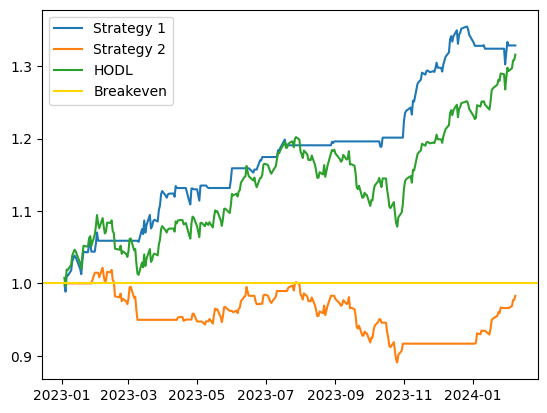

In [14]:
fig, ax = plt.subplots()
ax.plot(portfolio1_value, label="Strategy 1")
ax.plot(portfolio2_value, label="Strategy 2")
ax.plot(hodl_value, label="HODL")
ax.axhline(y=1, label="Breakeven", color="gold")
ax.legend(loc="upper left")
plt.show()


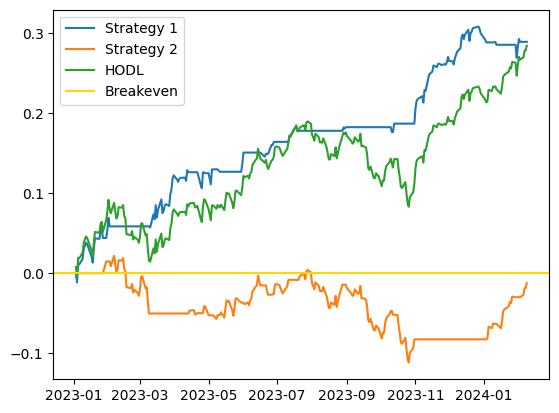

In [15]:
fig, ax = plt.subplots()
ax.plot(portfolio1_ret, label="Strategy 1")
ax.plot(portfolio2_ret, label="Strategy 2")
ax.plot(hodl_ret, label="HODL")
ax.axhline(y=0, label="Breakeven", color="gold")
ax.legend(loc="upper left")
plt.show()

In [16]:
# TODO: Add vertical lines to show when long and when neutral